<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import getpass
import dotenv
import wandb
import os
dotenv.load_dotenv(os.path.join('/homes/55/bwilop/wsg/private/', 'vscode-ssh.env'))
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

data_folder = '/homes/55/bwilop/wsg/data/'
experiment_folder = '/homes/55/bwilop/wsg/experiments/'

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [22]:
%load_ext autoreload
%autoreload 2
import torch as t
import torch.nn as nn
from torch.nn.functional import cross_entropy, softmax
from torch import Tensor
from jaxtyping import Float
from tqdm import tqdm
from transformer_lens import HookedTransformerConfig, HookedTransformer
import json
from typing import Callable, Any
import einops
import time
import uuid
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# Data

In [3]:
# tictactoe_data = cache_tictactoe_data(data_folder + 'tictactoe_data.pkl')
# tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random.pkl')
tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_NO_DIAGONAL.pkl')
print_data_statistics(tictactoe_data)

Shape Data:    torch.Size([100000, 10])
Shape Random:  torch.Size([100000, 10, 10])
Shape Weak:    torch.Size([100000, 10, 10])
Shape Strong:  torch.Size([100000, 10, 10])
--------------------------------------------------------
Evals Random:  {'weak_accuracy': 0.696753978729248, 'strong_accuracy': 0.662024974822998, 'illegal_move_chance': 0.0}
Evals Weak:    {'weak_accuracy': 1.0, 'strong_accuracy': 0.7386389970779419, 'illegal_move_chance': 0.0}
Evals Strong:  {'weak_accuracy': 0.7959870100021362, 'strong_accuracy': 1.0, 'illegal_move_chance': 0.0}
--------------------------------------------------------
Entropy Random:  1.2162327766418457
Entropy Weak:    0.6559994220733643
Entropy Strong:  0.6168825030326843
--------------------------------------------------------


In [4]:
# tictactoe_train_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe(tictactoe_data, 0.5, 0.25, 0.25, device, 1234)
tictactoe_train_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe_first_two_moves_no_overlap(tictactoe_data, 42, 15, 15, device, 1234)

print("Shape Train: ", tictactoe_train_data.games_data.shape)
print("Shape Validation: ", tictactoe_val_data.games_data.shape)
print("Shape Test:  ", tictactoe_test_data.games_data.shape)

Shape Train:  torch.Size([58224, 10])
Shape Validation:  torch.Size([20953, 10])
Shape Test:   torch.Size([20823, 10])


In [5]:
leakage_pct_weigted, leakage_pct = calculate_leakage_percentage(tictactoe_train_data, tictactoe_test_data)
print(f"Leakage Percentage Weighted: {leakage_pct_weigted:.2f}%")
print(f"Leakage Percentage: {leakage_pct:.2f}%")

Leakage Percentage Weighted: 20.00%
Leakage Percentage: 0.02%


In [6]:
# plot_train_test_prefix_histograms(tictactoe_train_data, tictactoe_test_data)

In [7]:
import torch.nn.functional as F

def sample_hard_labels_from_soft(soft_labels: t.Tensor, num_samples) -> t.Tensor:
    n_games, game_length, n_tokens = soft_labels.shape
    soft_labels_flat = soft_labels.view(-1, n_tokens)
    sampled_indices = t.multinomial(soft_labels_flat, num_samples=num_samples, replacement=True)

    one_hot_samples = F.one_hot(sampled_indices, num_classes=n_tokens).float()
    one_hot_samples = one_hot_samples.view(n_games, game_length, num_samples, n_tokens)
    one_hot_samples = one_hot_samples.permute(0, 2, 1, 3)
    new_hard_labels = one_hot_samples.reshape(n_games * num_samples, game_length, n_tokens)
    return new_hard_labels

def create_hard_label_tictactoe_data(data: TicTacToeData, num_samples, random_seed: int = 4567) -> TicTacToeData:
    t.manual_seed(random_seed)
    new_games_data = data.games_data.repeat_interleave(num_samples, dim=0)
    new_random_move_labels = sample_hard_labels_from_soft(data.random_move_labels, num_samples=num_samples)
    new_weak_goals_labels  = sample_hard_labels_from_soft(data.weak_goals_labels, num_samples=num_samples)
    new_strong_goals_labels = sample_hard_labels_from_soft(data.strong_goals_labels, num_samples=num_samples)
    return TicTacToeData(
        games_data=new_games_data,
        random_move_labels=new_random_move_labels,
        weak_goals_labels=new_weak_goals_labels,
        strong_goals_labels=new_strong_goals_labels
    )

tictactoe_train_data = create_hard_label_tictactoe_data(tictactoe_train_data, num_samples=1)
tictactoe_val_data = create_hard_label_tictactoe_data(tictactoe_val_data, num_samples=1)

In [8]:
print("Shape Train: ", tictactoe_train_data.games_data.shape)
tictactoe_train_data.random_move_labels[0]

Shape Train:  torch.Size([58224, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [9]:
print("Shape Train: ", tictactoe_val_data.games_data.shape)
tictactoe_val_data.random_move_labels[0]

Shape Train:  torch.Size([20953, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [10]:
print("Shape Test:  ", tictactoe_test_data.games_data.shape)
tictactoe_test_data.random_move_labels[0]

Shape Test:   torch.Size([20823, 10])


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.1250, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250,
         0.0000],
        [0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429,
         0.0000],
        [0.1667, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.1667, 0.1667,
         0.0000],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.2000, 0.0000, 0.2000, 0.2000,
         0.0000],
        [0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500,
         0.0000],
        [0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]], device='c

In [11]:
def sample_random_games(n_games: int) -> t.Tensor:
    games = []
    for _ in range(n_games):
        board = Board()
        while board.game_state == State.ONGOING:
            moves = board.get_possible_moves()
            if not moves: break
            board.make_move(random.choice(moves))
        seq = [10] + board.moves_played + [9] * (10 - len(board.moves_played))
        games.append(seq)
    return t.tensor(games)

def print_evaluate_overlap():
    train = sample_random_games(1000)
    test = sample_random_games(30000)

    # Full games
    train_full = [tuple(g.tolist()) for g in train]
    full_count = sum(1 for game in test.tolist() if tuple(game) in train_full)
    perc_full = 100 * full_count / len(test)

    # Subgames (all prefixes)
    def all_prefixes(games):
        prefs = []
        for game in games.tolist():
            for l in range(1, len(game)+1):
                prefs.append(tuple(game[:l]))
        return prefs

    train_prefs = set(all_prefixes(train))
    test_prefs = all_prefixes(test)
    subgame_count = sum(1 for p in test_prefs if p in train_prefs)
    perc_subgames = 100 * subgame_count / len(test_prefs)

    # Board states: unordered sets of moves (only valid moves 0-8)
    def board_states(games):
        states = []
        for game in games.tolist():
            for l in range(1, len(game)+1):
                state = frozenset(x for x in game[:l] if 0 <= x <= 8)
                states.append(state)
        return states

    train_states = set(board_states(train))
    test_states = board_states(test)
    state_count = sum(1 for s in test_states if s in train_states)
    perc_states = 100 * state_count / len(test_states)

    print(f"Test full games seen: {perc_full:.2f}%")
    print(f"Test subgames seen: {perc_subgames:.2f}%")
    print(f"Test board states seen: {perc_states:.2f}%")

# print_evaluate_overlap()
# 255k games
# We train on 50k games
# Test full games seen: 40.98%
# Test subgames seen: 77.87%
# Test board states seen: 100.00%

# Train model

In [12]:
# raise Exception()

### Parameters

In [24]:
training_cfg = {
    "learning_rate": 1e-3, # 1e-4,
    "weight_decay": 1e-4,  # 1e-5,
    "max_epochs": 1000,
    "early_stopping_patience": 5,
    "batch_size": 64,
}

model_sizes = {}
model_sizes["nano"]   = {"n_layers": 1, "n_heads": 1, "d_model": 1, "d_head": 1, "d_mlp": 4}
model_sizes["micro"]   = {"n_layers": 1, "n_heads": 2, "d_model": 4, "d_head": 2, "d_mlp": 16}
model_sizes["mini"]   = {"n_layers": 2, "n_heads": 4, "d_model": 8, "d_head": 2, "d_mlp": 32}

model_sizes["small"] = {"n_layers": 3, "n_heads": 4, "d_model": 16, "d_head": 4, "d_mlp": 64}
model_sizes["medium"] = {"n_layers": 4, "n_heads": 8, "d_model": 32, "d_head": 4, "d_mlp": 128}
model_sizes["large"] = {"n_layers": 5, "n_heads": 8, "d_model": 64, "d_head": 8, "d_mlp": 256}

model_sizes["huge"]   = {"n_layers": 6, "n_heads": 16, "d_model": 128, "d_head": 8,  "d_mlp": 512}
# model_sizes["gigantic"] = {"n_layers": 7, "n_heads": 16, "d_model": 256, "d_head": 16, "d_mlp": 1024}

# model_size_to_epochs = {
#                 # roughly converged after
#     "nano": 3,  # 1
#     "micro": 20,  # 10
#     "mini": 40,  # 20
#     "small": 50,  # 35
#     "medium": 4,  # 2
#     "large": 2,  # 1
#     # "huge": 1,
#     # "gigantic": 1
# }


def get_model_config(size: str):
    common_params = {
        "act_fn": "relu",
        "normalization_type": "LN",
        "d_vocab": 11,
        "d_vocab_out": 10,
        "n_ctx": 10,
        "init_weights": True,
        "device": "cuda",
        "seed": 1337,
    }
    specific = model_sizes[size]
    return HookedTransformerConfig(**specific, **common_params)

print_model_ratios(model_sizes, get_model_config)

Moving model to device:  cuda
nano 6.8 * 10^01
Moving model to device:  cuda
micro 3.9 * 10^02
Moving model to device:  cuda
mini 2.0 * 10^03
Moving model to device:  cuda
small 1.0 * 10^04
Moving model to device:  cuda
medium 5.2 * 10^04
Moving model to device:  cuda
large 2.5 * 10^05
Moving model to device:  cuda
huge 1.2 * 10^06
Ratio of consecutive model-sizes:  [5.676470588235294, 5.227979274611399, 5.142715559960357, 4.9992291385623435, 4.857985428472302, 4.736774029725204]


### wandb

### Train loop

In [31]:
from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

In [15]:
# project_name = "tictactoe_playground"
# model_size = "large"
# model_cfg = get_model_config(model_size)
# wandb.finish()
# model, _, _ = run_full_training(project_name, model_size, Goal.STRONG_GOAL, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, model_cfg)

### Experiments

In [ ]:
project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split"
# pretrain_models(experiment_folder, project_name, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, get_model_config)

Moving model to device:  cuda


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Early stopping triggered at epoch 26


generative/_check_if_illegal_moves,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
generative/_check_played_after_game_ends,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
generative/_check_played_repeat_moves,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
generative/inappropriate_end_state,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/illegal_move_chance,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/random_loss,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▅▆▆▆▆▇▆▆▆▆▇▆▇▇▇▇▇▇▇███████
test/strong_accuracy,▁▇▆█▆▃▆▆▆▆▆▆▃▆▇▃█▇▇▇▇█▆▇▆▃▇▇▆▆▆▆▇▆▇▅▇▅█▆
test/strong_loss,▁▁▁▁▁▂▃▃▄▄▅▄▅▅▅▅▅▆▆▅▅▅▆▇▆▆▆▆▇▅▆▇▆█▆▆▆▇▇▆
test/weak_accuracy,▁▅██████████████████████████▇█████████▇█
test/weak_loss,▇█▇▅▆▄▄▄▄▄▃▃▃▄▃▅▄▂▃▂▃▂▃▃▁▅▄▂▃▄▂▂▄▃▂▃▂▁▃▂
train/illegal_move_chance,▆▆▄▄▅▄▃▄▃▇▇▃▁▅▃▆▄▄▄▁▅▄▅█▄▅▅▄▄▂▅▃▇▃▂▄▅▂▄▂


Model saved to /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_huge_weak_2025-03-16-14-16_zwpp13rj.pkl
Moving model to device:  cpu
Moving model to device:  cuda


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Training batches:   0%|          | 0/910 [00:00<?, ?it/s]

Early stopping triggered at epoch 13


generative/_check_if_illegal_moves,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
generative/_check_played_after_game_ends,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
generative/_check_played_repeat_moves,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
generative/inappropriate_end_state,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/illegal_move_chance,█▅▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/random_loss,▁▂▁▂▂▂▃▃▃▃▃▃▃▃▃▄▃▃▄▃▃▄▄▅▄▅▅▆▅▆▅▆▇▆▆█▇▆▇▇
test/strong_accuracy,▁▆▆▇▇▇▇▇▇▇▇████████████▇██████▇▇███▇████
test/strong_loss,▇█▇▄▃▃▃▂▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▁▂
test/weak_accuracy,▁▅▃▄▄▆▆▅▅▇▅▅▆▆▇▅▆▆▇▆▅▇█▆▇▇▆▆▇▇▅▅▅▇▇▆▇▇▇▆
test/weak_loss,▃▁▁▂▂▃▃▄▂▃▃▃▄▂▄▄▄▄▄▅▅▅▅▄▇▆▆▆▇▆█▆▆▆▆▇▇█▇▇
train/illegal_move_chance,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Model saved to /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_huge_strong_2025-03-16-14-35_gz5eav8q.pkl
Moving model to device:  cpu


Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_nano_weak_2025-03-16-13-02_6grwjeyg.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_nano_strong_2025-03-16-13-04_ic1eb75q.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_micro_weak_2025-03-16-13-07_v9nchi68.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_micro_strong_2025-03-16-13-12_bg28wyjd.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_mini_weak_2025-03-16-13-14_t7xv22jn.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg

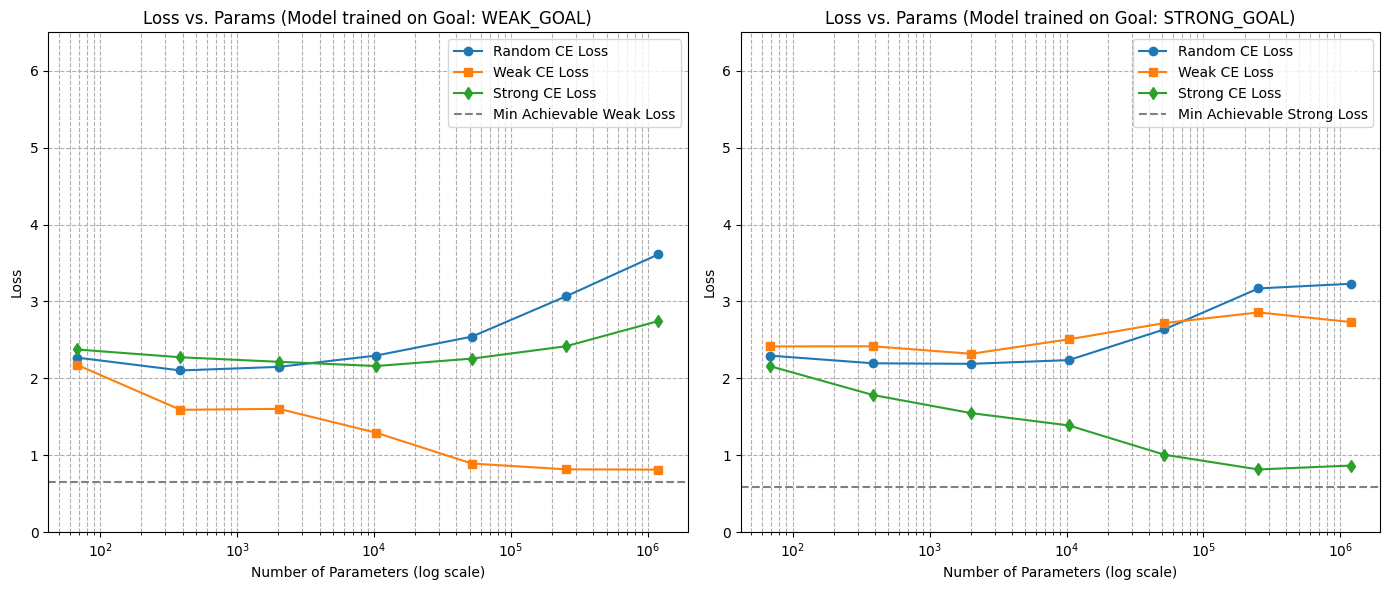

In [29]:
plot_loss_pretrain_models(experiment_folder, project_name, tictactoe_test_data)

In [33]:
project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split"
weak_model_weak_goals = load_model(project_name, "mini", Goal.WEAK_GOAL, experiment_folder)
strong_model_weak_goals = load_model(project_name, "medium", Goal.WEAK_GOAL, experiment_folder)
strong_model_strong_goals = load_model(project_name, "medium", Goal.STRONG_GOAL, experiment_folder)
quick_evaluation("Weak model weak goal", weak_model_weak_goals, tictactoe_test_data)
quick_evaluation("Strong model weak goal", strong_model_weak_goals, tictactoe_test_data)
quick_evaluation("Strong model strong goal", strong_model_strong_goals, tictactoe_test_data)
strong_model_finetuned = deepcopy(strong_model_strong_goals)

adapted_training_cfg = deepcopy(training_cfg)
adapted_training_cfg["epochs"] = 20

project_name = "tictactoe_playground"
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
experiment_name = f"experiment_finetuning_{timestamp}"
finetune_strong_with_weak(project_name, experiment_name, weak_model_weak_goals, strong_model_finetuned, tictactoe_train_data, tictactoe_test_data, adapted_training_cfg)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f66fc497a90>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f66fc7b9990, raw_cell="project_name = "tictactoe_pretrained_forbidden_dia.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Btorrnode1/homes/55/bwilop/wsg/WSG_games/playground_WSG_games.ipynb#X34sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_mini_weak_2025-03-16-13-14_t7xv22jn.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_medium_weak_2025-03-16-13-30_3uudsequ.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_forbidden_diagonals_no_overlap_split/experiment_medium_strong_2025-03-16-13-40_6rg1q835.pkl
Weak model weak goal
weak_loss:  1.6008632183074951
strong_loss:  2.2484512329101562
Strong model weak goal
weak_loss:  0.8857359290122986
strong_loss:  2.231412410736084
Strong model strong goal
weak_loss:  2.722717761993408
strong_loss:  1.0189193487167358


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f66fc497a90>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f66fc78b350, execution_count=33 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7f66fc7b9990, raw_cell="project_name = "tictactoe_pretrained_forbidden_dia.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Btorrnode1/homes/55/bwilop/wsg/WSG_games/playground_WSG_games.ipynb#X34sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [19]:
# quick_evaluation("Weak model weak goal", weak_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model weak goal", strong_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model strong goal", strong_model_strong_goals, tictactoe_test_data)
# quick_evaluation("Strong model weakly-finetuned to weak goal", strong_model_finetuned, tictactoe_test_data)

# Inspect model

In [20]:
# project_name = "tictactoe_pretrained_different_epochs"
# model = load_model(project_name, "medium", Goal.WEAK_GOAL, experiment_folder)
# quick_evaluation("model weak goal", model, tictactoe_test_data)

In [21]:
W = model.embed.W_E
W_normed = W / W.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix and move to CPU as a NumPy array
cosine_sim = (W_normed @ W_normed.T).detach().cpu().numpy()

im = plt.imshow(cosine_sim)
plt.title("Cosine similarities of each pair of 2D feature embeddings")
plt.gcf().set_size_inches(6, 6)

# Add a colorbar with a label
cbar = plt.colorbar(im)
cbar.set_label("Cosine similarity value")

plt.show()

NameError: name 'model' is not defined

In [ ]:
W.shape

In [ ]:
train_sample = random_sample_tictactoe_data(tictactoe_train_data, 1)
train_logits = model(train_sample.games_data)
soft_labels = softmax(train_logits, dim=-1)
hard_labels = F.one_hot(train_sample.weak_goals_labels.argmax(dim=-1), num_classes=train_logits.shape[-1]).float()

print(train_sample.weak_goals_labels.shape)
print(train_logits.shape)
print(soft_labels.shape)
print(hard_labels.shape)

In [ ]:
train_sample.weak_goals_labels

In [ ]:
soft_labels.clip(0.01)

In [ ]:
hard_labels

In [ ]:
board = Board()
print(get_best_moves(board, Goal.WEAK_GOAL))
board.make_move(1)
print(get_best_moves(board, Goal.WEAK_GOAL))

In [ ]:
tictactoe_test_data.games_data[600]

In [ ]:
tictactoe_test_data.weak_goals_labels[2]

In [ ]:
tictactoe_test_data.games_data[25][:]

In [ ]:
softmax(model(tictactoe_test_data.games_data[25][:]), dim=-1).clip(0.01)

In [ ]:
skip_to = 0
train_dataset = TensorDataset(
    tictactoe_test_data.games_data,
    tictactoe_test_data.random_move_labels,
    tictactoe_test_data.weak_goals_labels,
    tictactoe_test_data.strong_goals_labels,
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
i = 0
# for games, random_labels, weak_labels, strong_labels in tqdm(train_loader, desc="Training batches", leave=False, position=1, dynamic_ncols=True):
#     # if i == 25:
#     # print(games)
#     logits = model(games)
#     # print(logits)
#     print(i, cross_entropy(logits, weak_labels))
#     # raise Exception()
#     i += 1
#     if i > 100:
#         raise Exception()

In [ ]:
visualize_game(tictactoe_test_data, game_id=25, model=model)

# Sample games

In [ ]:
samples = sample_games(model, 1, 100)

In [ ]:
evals.eval_model(samples)

In [ ]:
sample = samples[1]
print(sample)

In [ ]:
from alphatoe.game import Board, State

def check(game: list[int]) -> bool:
    board = Board()
    for move in game[1:-1]:
        print(move)
        if board.game_state == State.ONGOING:
            try:
                board.make_move(move)
            except:
                return True
        elif move == 9:
            pass
        else:
            return True
    return False

check(sample)

In [ ]:
game.play_game(sample)
print("\nPLAY:")
board = game.Board()
for move in sample:
  if move not in [9, 10]:
    board.make_move(move)
    board.draw_board()
    print(".")

In [ ]:
print(evals.model_vs_minimax(model, True), "\n")
print(evals._check_minimax_win_rate(model, 100))

In [ ]:
evals.get_error_rate(samples)